# Rag-based LLM Application

## Set up

In [1]:
import os
import openai
from pathlib import Path
from pprint import pprint
import ray
from tqdm import tqdm
import sys; sys.path.append("..")

In [2]:
from app.config import ROOT_DIR

In [7]:
# OpenAI key
openai.api_key = ""  # https://platform.openai.com/account/api-keys

In [8]:
# Database credentials
DB_CONNECTION_STRING = "dbname=postgres user=postgres host=localhost password=postgres"
ray.init(runtime_env={"env_vars": {"DB_CONNECTION_STRING": DB_CONNECTION_STRING}, "working_dir": ROOT_DIR})

2023-08-16 16:56:13,595	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 10.0.11.188:6379...
2023-08-16 16:56:13,636	INFO worker.py:1612 -- Connected to Ray cluster. View the dashboard at https://session-nblwa64m553kfm289wcbiq9syg.i.anyscaleuserdata-staging.com 
2023-08-16 16:56:13,664	INFO packaging.py:518 -- Creating a file package for local directory '/home/ray/ray-qa/notebooks/..'.
2023-08-16 16:56:13,689	INFO packaging.py:346 -- Pushing file package 'gcs://_ray_pkg_57e9aa0a9986774b.zip' (1.08MiB) to Ray cluster...
2023-08-16 16:56:13,693	INFO packaging.py:359 -- Successfully pushed file package 'gcs://_ray_pkg_57e9aa0a9986774b.zip'.


Python version:,3.9.15
Ray version:,2.6.2
Dashboard:,http://session-nblwa64m553kfm289wcbiq9syg.i.anyscaleuserdata-staging.com


## Load data

Our data is already ready at `/efs/shared_storage/pcmoritz/docs.ray.io/en/master/` (on Staging) but if you wanted to load it yourself, run this bash command (change `/desired/output/directory`):
```bash
wget -e robots=off --recursive --no-clobber --page-requisites --html-extension --convert-links --restrict-file-names=windows --domains docs.ray.io --no-parent --accept=html -P /desired/output/directory https://docs.ray.io/en/master/
```

In [10]:
# Ray dataset
docs_path = Path("/efs/shared_storage/pcmoritz/docs.ray.io/en/master/")
ds = ray.data.from_items([{"path": path} for path in docs_path.rglob("*.html") if not path.is_dir()])
print(f"{ds.count()} documents")

3294 documents


## Process data

### Sections

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from app.index import parse_file

In [12]:
# Sample
record = {"path": "/efs/shared_storage/pcmoritz/docs.ray.io/en/master/train/faq.html"}
pprint(parse_file(record)[:3])  # just first few chunks

[{'source': 'https://docs.ray.io/en/master/train/faq.html', 'text': '\n\n\n'},
 {'source': 'https://docs.ray.io/en/master/train/faq.html#ray-train-faq',
  'text': 'Ray Train FAQ#\n\n'},
 {'source': 'https://docs.ray.io/en/master/train/faq.html#how-fast-is-ray-train-compared-to-pytorch-tensorflow-etc',
  'text': 'How fast is Ray Train compared to PyTorch, TensorFlow, etc.?#\n'
          'At its core, training speed should be the same - while Ray Train '
          'launches distributed training workers via Ray Actors,\n'
          'communication during training (e.g. gradient synchronization) is '
          'handled by the backend training framework itself.\n'
          'For example, when running Ray Train with the TorchTrainer,\n'
          'distributed training communication is done with Torch’s '
          'DistributedDataParallel.\n'
          'Take a look at the Pytorch and Tensorflow benchmarks to check '
          'performance parity.\n'
          '\n'
          '\n'}]


/home/ray/ray-qa/notebooks/../app/index.py:19: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 19 of the file /home/ray/ray-qa/notebooks/../app/index.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(f.read())


In [13]:
# Extract sections
sections_ds = ds.flat_map(parse_file)
sections = sections_ds.take_all()
print (len(sections))

2023-08-16 16:56:29,334	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(parse_file)]
2023-08-16 16:56:29,335	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-16 16:56:29,335	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(FlatMap(parse_file) pid=112387) /tmp/ray/session_2023-08-16_15-05-26_482090_2474/runtime_resources/working_dir_files/_ray_pkg_57e9aa0a9986774b/app/index.py:19: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.
(FlatMap(parse_file) pid=112387) 
(FlatMap(parse_file) pid=112387) The code that caused this warning is on line 19 of the file /tmp/ray/session_2023-08-16_15-05-26_482090_2474/runtime_resources/working_dir_files/_ray_pkg_57e9aa0a9986774b/app/index.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.
(FlatMap(parse_file) pid=112387) 
(FlatMap(parse_file) pid=112387)   soup = BeautifulSoup(f.read())
(FlatMap(parse_file) pid=112407) /tmp/ray/session_2023-08-16_15-05-26_482090_2474

8914


In [17]:
# Stats summary
sections_lengths = [len(section["text"]) for section in sections]
series = pd.Series(sections_lengths)
series.describe()

count      8914.000000
mean       1335.308167
std        5963.168522
min           3.000000
25%           3.000000
50%         251.000000
75%         809.000000
max      208012.000000
dtype: float64

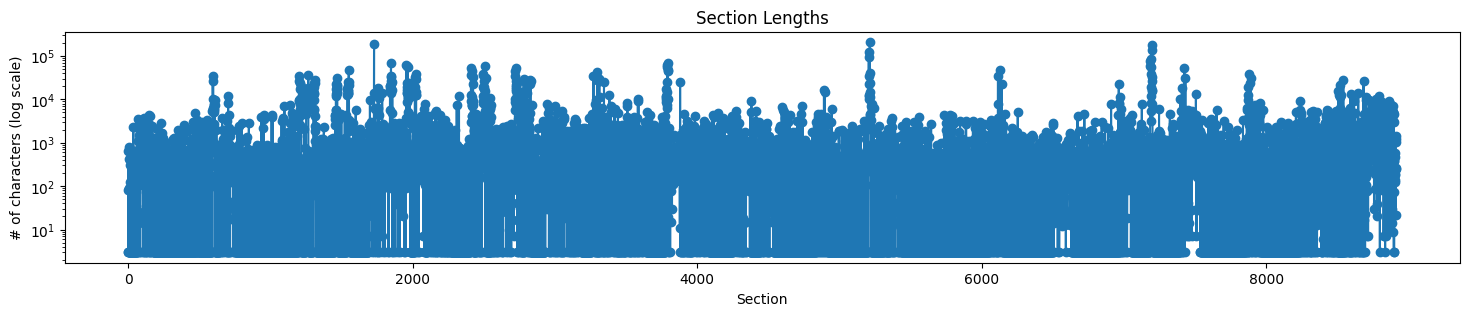

In [23]:
# Sections lengths
plt.figure(figsize=(18, 3))
plt.semilogy(sections_lengths, marker='o')
plt.xlabel('Section')
plt.ylabel('# of characters (log scale)')
plt.title('Section Lengths')
plt.show()

### Chunks

Some of these sections are very large, let's apply some chunking to improve this so that we can use these sections as context later.

In [24]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [25]:
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=300,
    chunk_overlap=50,
    length_function=len,
)

In [26]:
chunks = text_splitter.create_documents(
    texts=[section["text"] for section in sections], 
    metadatas=[{"source": section["source"]} for section in sections]
)

In [27]:
print (f"{len(chunks)} chunks\n")
pprint (chunks[0].page_content)  # a few tokens
print (f"\nmetadata:\n{chunks[0].metadata}")

57836 chunks

'ray.tune.search.hyperopt.HyperOptSearch.add_evaluated_trials#'

metadata:
{'source': 'https://docs.ray.io/en/master/tune/api/doc/ray.tune.search.hyperopt.HyperOptSearch.add_evaluated_trials.html#ray-tune-search-hyperopt-hyperoptsearch-add-evaluated-trials'}


In [28]:
# Ray dataset
chunks_ds = ray.data.from_items([{"text": chunk.page_content, "source": chunk.metadata["source"]} for chunk in chunks])

### Embed data

In [29]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import numpy as np
from ray.data import ActorPoolStrategy

In [30]:
embedding_model = "thenlper/gte-base"

In [31]:
class EmbedNodes:
    def __init__(self, model_name):
        self.embedding_model = HuggingFaceEmbeddings(
            model_name=model_name,
            model_kwargs={"device": "cuda"},
            encode_kwargs={"device": "cuda", "batch_size": 100})
    
    def __call__(self, batch):
        embeddings = self.embedding_model.embed_documents(batch["text"])
        return {"text": batch["text"], "source": batch["source"], "embeddings": embeddings}

In [32]:
# Embed nodes
embedded_nodes = chunks_ds.map_batches(
    EmbedNodes,
    fn_constructor_kwargs={"model_name": embedding_model},
    batch_size=100, 
    num_gpus=1,
    compute=ActorPoolStrategy(size=2))

In [33]:
# Sample
sample = embedded_nodes.take(5)
print ("embedding size:", len(sample[1]["embeddings"]))
pprint(sample[1]["text"])

2023-08-16 17:05:38,683	INFO dataset.py:2180 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2023-08-16 17:05:38,685	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(EmbedNodes)]
2023-08-16 17:05:38,686	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-16 17:05:38,687	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-08-16 17:05:38,705	INFO actor_pool_map_operator.py:117 -- MapBatches(EmbedNodes): Waiting for 2 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2023-08-16 17:06:05,332	WARNING actor_pool_map_operator.py:275 -- To ensure full parallelization across an actor pool of size 2, the Dataset should consist of at least 2 distinct blocks. Consider increasing the parallelism when creating the Dataset.


embedding size: 768
('HyperOptSearch.add_evaluated_trials(trials_or_analysis: Union[Trial, '
 'List[Trial], ExperimentAnalysis], metric: str)#\n'
 'Pass results from trials that have been evaluated separately.\n'
 'This method allows for information from outside the\n'
 'suggest - on_trial_complete loop to be passed to the search')


### Index data

In [31]:
import os
import psycopg
from pgvector.psycopg import register_vector

In [32]:
class StoreResults:
    def __call__(self, batch):
        with psycopg.connect(DB_CONNECTION_STRING) as conn:
            register_vector(conn)
            with conn.cursor() as cur:
                for text, source, embedding in zip(batch["text"], batch["source"], batch["embeddings"]):
                    cur.execute('INSERT INTO document (text, source, embedding) VALUES (%s, %s, %s)', (text, source, embedding,))
        return {}

In [33]:
results = embedded_nodes.map_batches(
    StoreResults,
    batch_size=128,
    num_cpus=1,
    compute=ActorPoolStrategy(size=20)
).count()

2023-08-14 08:23:13,942	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(EmbedNodes)] -> ActorPoolMapOperator[MapBatches(StoreResults)]
2023-08-14 08:23:13,943	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-14 08:23:13,944	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-08-14 08:23:13,962	INFO actor_pool_map_operator.py:117 -- MapBatches(EmbedNodes): Waiting for 2 pool actors to start...
2023-08-14 08:23:31,902	INFO actor_pool_map_operator.py:117 -- MapBatches(StoreResults): Waiting for 20 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2023-08-14 08:31:15,804	WARNING actor_pool_map_operator.py:267 -- To ensure full parallelization across an actor pool of size 20, the specified batch size should be at most 0. Your configured batch size for this operator was 128.


### Retrieval

In [34]:
import json
import numpy as np

In [37]:
embedding_model = HuggingFaceEmbeddings(model_name=embedding_model)
conn = psycopg.connect(DB_CONNECTION_STRING)
register_vector(conn)

In [38]:
# Embed query
query = "What is the default batch size for map_batches?"
embedding = np.array(embedding_model.embed_query(query))
len(embedding)

768

In [39]:
with conn.cursor() as cur:
    cur.execute('SELECT * FROM document ORDER BY embedding <-> %s LIMIT 5', (embedding,))
    rows = cur.fetchall()
    context = [{"text": row[2], "source": row[1]} for row in rows]

In [41]:
pprint(context[0])

{'source': 'entire blocks as batches (blocks may contain different numbers of '
           'rows).\n'
           'The actual size of the batch provided to fn may be smaller than\n'
           'batch_size if batch_size doesn’t evenly divide the block(s) sent\n'
           'to a given map task. Default batch_size is 4096 with “default”.',
 'text': 'https://docs.ray.io/en/master/data/api/doc/ray.data.Dataset.map_batches.html#ray-data-dataset-map-batches'}


### Generation

In [103]:
def generate_response(llm, system_content, assistant_content, user_content, max_retries=3, retry_interval=60):
    retry_count = 0
    while retry_count < max_retries:
        try:
            response = openai.ChatCompletion.create(
                    model=llm,
                    messages=[
                        {"role": "system", "content": system_content},
                        {"role": "assistant", "content": assistant_content},
                        {"role": "user", "content": user_content},
                    ])
            return response["choices"][-1]["message"]["content"]
        except Exception as e:
            print (e)
            time.sleep(retry_interval)  # default is per-minute rate limits
            retry_count += 1
    return ""

In [43]:
# Generate response
generate_response(
    model="gpt-4",
    system_content="Answer the {query} using the provided {context}",
    assistant_content="", 
    user_content=f"query: {query}, context: {context}"
)

'The default batch size for map_batches is 4096.'

### References

In [44]:
import re
import time

We'll start by creating our reference (ground-truth) dataset. We have a list of user queries and the ideal source to answer the query with inside `eval/reference.jsonl`. We will our LLM app above to generate reference answer for each query/source pair using GPT 4.

In [45]:
llm = "gpt-4"
max_context_length = 8192

In [46]:
with open(Path(ROOT_DIR, "datasets/eval-dataset-v1.jsonl"), "r") as f:
    data = [json.loads(item) for item in list(f)]

In [47]:
# Clean up
for row in data:
    row["source"] = row["source"].replace("https://docs.ray.io/en/latest/", "https://docs.ray.io/en/master/")

In [48]:
data[:5]

[{'question': 'I’m struggling a bit with Ray Data type conversions when I do map_batches. Any advice?',
  'source': 'https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-format'},
 {'question': 'How does autoscaling work in a Ray Serve application?',
  'source': 'https://docs.ray.io/en/master/serve/scaling-and-resource-allocation.html#autoscaling'},
 {'question': 'can i create my own ray image with custom python version',
  'source': ''},
 {'question': 'how do I get the address of a ray node',
  'source': 'https://docs.ray.io/en/master/ray-core/miscellaneous.html#node-information'},
 {'question': 'are you based on GPT-4?', 'source': ''}]

In [ ]:
# Section per document (page) dict
sections_per_doc = {section["source"]: section["text"] for section in sections}
for section in sections:
    page = section["source"]
    if "#" not in page:
        page_sections = [key for key in sections_per_doc.keys() if key.startswith(page)]
        combined_text = "\n".join(sections_per_doc[page_section] for page_section in page_sections)
        sections_per_doc[page] = combined_text

In [ ]:
sections_per_doc['https://docs.ray.io/en/master/train/key-concepts.html']

In [49]:
# Checking if any sources are not in our parsed sources
for i, row in enumerate(data):
    if row["source"].startswith("https://docs.ray.io"):
        if row["source"] not in sections_per_doc:
            print(i, row["source"])

In [50]:
def extract_from_response(response):
    # Define regular expressions for extracting values
    answer_pattern = r'"answer"\s*:\s*"([^"]*)"'
    score_pattern = r'"score"\s*:\s*([0-9]+)'
    reasoning_pattern = r'"reasoning"\s*:\s*"([^"]*)"'

    # Extract values using regular expressions
    answer_match = re.search(answer_pattern, response)
    score_match = re.search(score_pattern, response)
    reasoning_match = re.search(reasoning_pattern, response)

    # Convert
    if answer_match and score_match and reasoning_match:
        answer = answer_match.group(1)
        score = float(score_match.group(1))
        reasoning = reasoning_match.group(1)
        return answer, score, reasoning

    return "", "", ""

In [53]:
# Content for inference
system_content = """
    Your job is {answer} a {query} using the additional {context} provided.
    Then, you must {score} your response between 1 and 5.
    You must return your response in a line with only the score.
    Do not add any more details.
    On a separate line provide your {reasoning} for the score as well.
    Return your response following the exact format outlined below.
    Do not add or remove anything.
    And all of this must be in a valid JSON format.
    
    {"answer": answer,
     "score": score,
     "reasoning": reasoning}
    """
assistant_content = ""
context_length = max_context_length - len(system_content + assistant_content)

In [55]:
# Generate response
results = []
for row in tqdm(data):
    # Get context
    query = row["question"]
    context = sections_per_doc.get(row["source"], "")
    
    # Generate response
    user_content = f"The query is {query} and the additional context is {context}"[:context_length]
    response = generate_response(
        llm=llm, 
        system_content=system_content, 
        assistant_content=assistant_content, 
        user_content=user_content)
    
    # Extract from response
    answer, score, reasoning = extract_from_response(response=response)
    
    # Store result
    result = ({
            "question": query,
            "source": row["source"],
            "answer": answer,
            "score": score,
            "reasoning": reasoning,
        })
    results.append(result)

100%|██████████| 189/189 [1:03:59<00:00, 20.31s/it]


In [58]:
# Rerun errors (We could use function calling but we might use OSS LLM as evaluator)
error_indices = [i for i, row in enumerate(results) if row["answer"] == "" and row["source"].startswith("https://docs.ray.io")]
for i in tqdm(error_indices):
    row = results[i]
    query = row["question"]
    context = sections_per_doc.get(row["source"], "")
    user_content = f"The question is {query} and the additional context is {context}"[:max_context_length]
    response = generate_response(
        llm=llm, 
        system_content=system_content, 
        assistant_content=assistant_content, 
        user_content=user_content)
    answer, score, reasoning = extract_from_response(response=response)
    result = ({
            "question": query,
            "source": row["source"],
            "answer": answer,
            "score": score,
            "reasoning": reasoning,
        })
    results[i] = result

100%|██████████| 7/7 [03:30<00:00, 30.08s/it]


Rerun the above cell until no errors in extraction.

In [60]:
# Save to file
with open(Path(ROOT_DIR, "datasets", "gpt4-with-source.json"), "w") as fp:
    json.dump(results, fp, indent=4)

### Inference

Now we're ready to perform inference using an LLM.

In [61]:
llm = "gpt-3.5-turbo-16k"
max_context_length = 16384

In [62]:
# Load questions 
with open(Path(ROOT_DIR, "datasets/gpt4-with-source.json"), "r") as f:
    questions = [json.loads(item)["question"] for item in list(f)]

In [67]:
# Content for inference
system_content = "Answer the question using the additional context provided."
assistant_content = ""
context_length = max_context_length - len(system_content + assistant_content)

In [85]:
# Generate response
results = []
for query in tqdm(questions):
    # Get context
    embedding = np.array(embedding_model.embed_query(query))
    with conn.cursor() as cur:
        cur.execute('SELECT * FROM document ORDER BY embedding <-> %s LIMIT 5', (embedding,))
        rows = cur.fetchall()
        context = [{"text": row[1]} for row in rows]
        sources = [row[2] for row in rows]
        
    # Generate response
    user_content = f"The question is {query} and the additional context is {context}"[:context_length]
    answer = generate_response(
        llm=llm, 
        system_content=system_content, 
        assistant_content=assistant_content, 
        user_content=user_content)

    # Store result
    result = ({
            "question": query,
            "sources": sources,
            "answer": answer,
        })
    results.append(result)

100%|██████████| 189/189 [54:22<00:00, 17.26s/it] 


### Evaluation

Evalute our LLM (ex. Llama 2, GPT 3.5, etc.) on our reference dataset.

In [95]:
llm = "gpt-4"
max_context_length = 8192

In [96]:
# Load answers
with open(Path(ROOT_DIR, "datasets/gpt4-with-source.json"), "r") as f:
    references = [item for item in json.load(f)]
generated = results
assert len(references) == len(generated)

In [97]:
# Retrieval score
matches = np.zeros(len(references))
for i in range(len(references)):
    reference_source = references[i]["source"].split("#")[0]
    if not reference_source:
        matches[i] = 1
        continue
    for source in generated[i]["sources"]:
        if reference_source == source.split("#")[0]:  # sections don't have to perfectly match
            matches[i] = 1
            continue
print (np.mean(matches))

In [100]:
# Content
system_content = """
    Your job is to rate the quality of our generated answer {generated_answer}
    given a query {query} and a reference answer {reference_answer}.
    Your score has to be between 1 and 5.
    You must return your response in a line with only the score.
    Do not return answers in any other format.
    On a separate line provide your reasoning for the score as well.
    """
assistant_content = ""
context_length = max_context_length - len(system_content + assistant_content)

In [108]:
# Generate response
results = []
for ref, gen in tqdm(zip(references, generated), total=len(references)):
    # User prompt
    assert ref["question"]==gen["question"]
    user_content = str({
        "question": gen["question"],
        "generated_answer": gen["answer"],
        "reference_answer": ref["answer"]
    })[:context_length]
    
    # Generate response
    response = generate_response(
        llm=llm,
        system_content=system_content, 
        assistant_content="", 
        user_content=user_content)
    
    # Extract from response
    score, reasoning = response.split("\n", 1)

    # Store result
    result = {
        "question": gen["question"],
        "generated_answer": gen["answer"],
        "reference_answer": ref["answer"],
        "score": float(score),
        "reasoning": reasoning.lstrip("\n"),
    }
    results.append(result)

100%|██████████| 189/189 [25:41<00:00,  8.15s/it]


In [111]:
# Quality score
np.mean([item["score"] for item in results])